### General results for all cell types. 


* general counts of credible sets


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re

import upsetplot as up
from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

# set higher figure resolution (for poster)
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000


In [5]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
eqtl_output_dir = config['eqtl_output_dir']
pcqtl_output_dir = config['pcqtl_output_dir']

# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])

### How many credible sets across tissues?
number of pcqtl and eqtl credible sets

In [6]:
# load in the susie data
susie_control={}
susie_pc={}

for tissue_id in tissue_df['Tissue']:
    # load in eqtl susie output
    susie_control[tissue_id] = pd.read_csv(f'{prefix}/{eqtl_output_dir}/{tissue_id}/{tissue_id}.v8.cluster_genes.susie.txt', sep='\t', index_col=0)
    # load in pcqtl susie output
    susie_pc[tissue_id] = pd.read_csv(f'{prefix}/{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pcs.susie.txt', sep='\t', index_col=0)
    # add in pc num column
    susie_pc[tissue_id]['pc_num'] = susie_pc[tissue_id]['phenotype_id'].str.split('_pc').str[-1].astype(int)
    # add in cluster size column
    susie_pc[tissue_id]['cluster_size'] = susie_pc[tissue_id]['phenotype_id'].str.split('_').apply(len) - 1

In [7]:
# load in the clusters data
clusters = []
for t in tissue_df['Tissue']:
    clusters.append(pd.read_csv(f'{prefix}/{clusters_dir}/{t}_clusters_all_chr.csv'))
clusters_df = pd.concat(clusters, keys=tissue_df['Tissue'])


In [8]:
# function to get the number of credible sets
def get_num_cs(susie_df):
    return len(susie_df.groupby(['phenotype_id','cs_id']))

In [9]:
# create a dataframe with the number of credible sets for each tissue 
cs_counts_df = pd.DataFrame({'tissue':tissue_df['Tissue'], 
                       'num_control': [get_num_cs(susie_control[t]) for t in tissue_df['Tissue']], 
                       'num_pc1': [get_num_cs(susie_pc[t][susie_pc[t]['pc_num']==1]) for t in tissue_df['Tissue']], 
                       'num_pc2': [get_num_cs(susie_pc[t][susie_pc[t]['pc_num']==2]) for t in tissue_df['Tissue']], 
                       'num_pc3': [get_num_cs(susie_pc[t][susie_pc[t]['pc_num']==3]) for t in tissue_df['Tissue']], 
                       'num_pc4+': [get_num_cs(susie_pc[t][susie_pc[t]['pc_num']>3]) for t in tissue_df['Tissue']], 
                       'num_clusters':[sum(clusters_df['Tissue'] == t) for t in tissue_df['Tissue']]})


In [10]:
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))
tissue_pal

[(0.7215686274509804, 0.22745098039215686, 0.29411764705882354),
 (0.7667820069204152, 0.3172318339100346, 0.26440599769319495),
 (0.81199538638985, 0.40701268742791236, 0.23469434832756633),
 (0.859361783929258, 0.5010688196847367, 0.20356785851595538),
 (0.9045751633986928, 0.5908496732026144, 0.1738562091503268),
 (0.9497885428681276, 0.6806305267204922, 0.1441445597846982),
 (0.993756247597078, 0.7722106881968474, 0.11650903498654364),
 (0.8962245290272972, 0.758000768935025, 0.23341791618608226),
 (0.7986928104575164, 0.7437908496732026, 0.3503267973856209),
 (0.6965167243367936, 0.7289042675893888, 0.4728027681660899),
 (0.5989850057670127, 0.7146943483275663, 0.5897116493656285),
 (0.5014532871972318, 0.7004844290657439, 0.7066205305651673),
 (0.403921568627451, 0.6862745098039216, 0.8235294117647058)]

/local/scratch/klawren/slrmtmp.44895482/ipykernel_40429/225402753.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['eqtl', 'pc1qtl', 'pc2qtl', 'pc3qtl','pc4+qtl', 'clusters'])


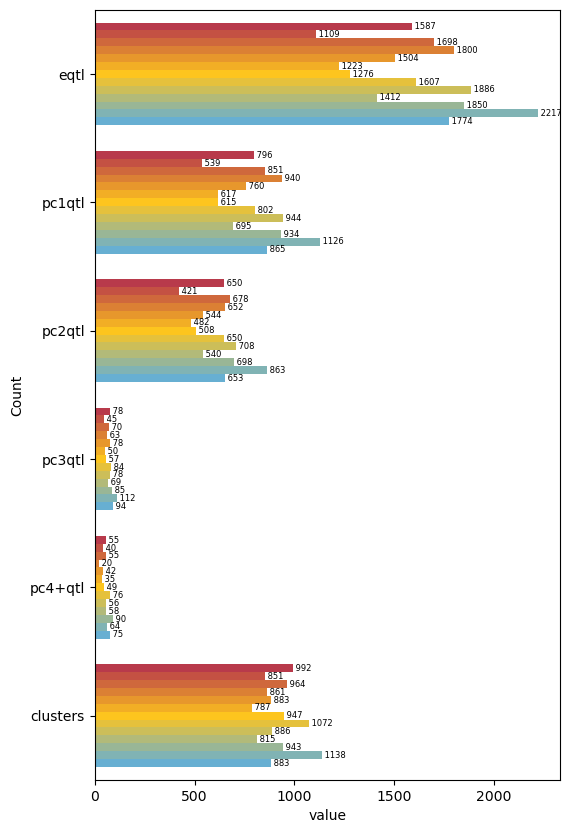

In [11]:
f, ax = plt.subplots(figsize=(6, 10))
y = sns.barplot(pd.melt(cs_counts_df, id_vars=['tissue']), x='value', hue='tissue', y='variable', ax=ax, palette=tissue_pal, saturation=1)
for i in range(len(y.containers)):
    labels = [' ' + str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels, rotation=0,  fontsize=6)
ax.set_ylabel('Count')
ax.set_yticklabels(['eqtl', 'pc1qtl', 'pc2qtl', 'pc3qtl','pc4+qtl', 'clusters'])
plt.legend([],[], frameon=False)

plt.show()

## poster

* clusters per tissue
* cluster size distribution per tissue
* pcqtls per tissue

/local/scratch/klawren/slrmtmp.44895482/ipykernel_40429/4080252346.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


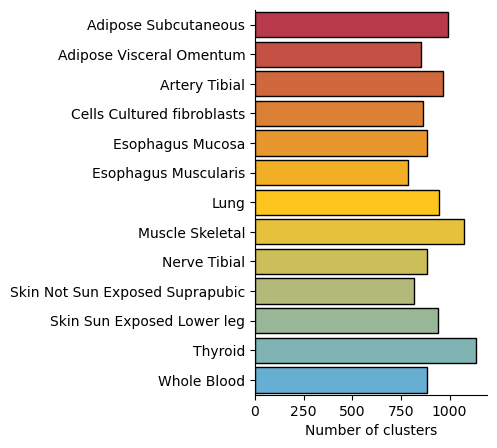

In [12]:
# plot showing number of clusters in each tissue

fig, ax = plt.subplots(figsize=(3,5))

ax = sns.barplot(cs_counts_df, x='num_clusters', hue='tissue', y='tissue', palette=tissue_pal, saturation=1, edgecolor='k', width=.85, ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

ax.set_xlabel('Number of clusters')
ax.set_ylabel('')

plt.show()


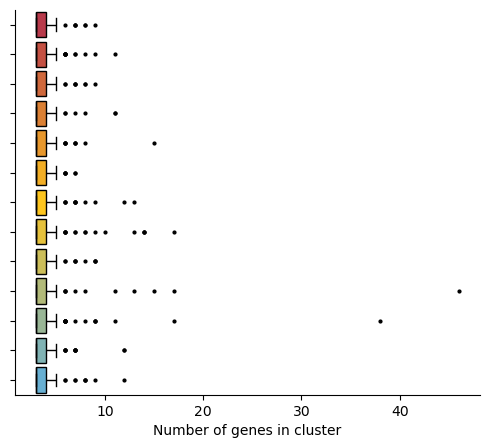

In [13]:
# plot showing distribution of clsuter sizes in each tissue
clusters_df['num_genes'] = clusters_df['Transcripts'].str.split(',').apply(len)


fig, ax = plt.subplots(figsize=(6,5))


PROPS = {
    'boxprops':{ 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}, 
    'flierprops':{'markerfacecolor':'k', 'markersize':2,'linestyle':'none', 'markeredgecolor':'k',}}

sns.boxplot(clusters_df[clusters_df['num_genes']>2], x='num_genes', hue='Tissue', y='Tissue', ax=ax, palette=tissue_pal, saturation=1, width=.85, **PROPS)

# remove labels
ax.set_yticklabels('')

ax.set_xlabel('Number of genes in cluster')
ax.set_ylabel('')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [15]:
counts = pd.DataFrame({'tissue':tissue_df['Tissue'], 
                       'eQTL': [get_num_cs(susie_control[t]) for t in tissue_df['Tissue']], 
                       'num_pc1': [get_num_cs(susie_pc[t][susie_pc[t]['pc_num']==1]) for t in tissue_df['Tissue']], 
                       'num_pcother': [get_num_cs(susie_pc[t][(susie_pc[t]['pc_num']>1)]) for t in tissue_df['Tissue']]})

In [17]:
mpl.rcParams['figure.dpi']= 1000


/local/scratch/klawren/slrmtmp.44895482/ipykernel_40429/426307221.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['eQTL', 'first pcQTL', 'other pcQTL'])


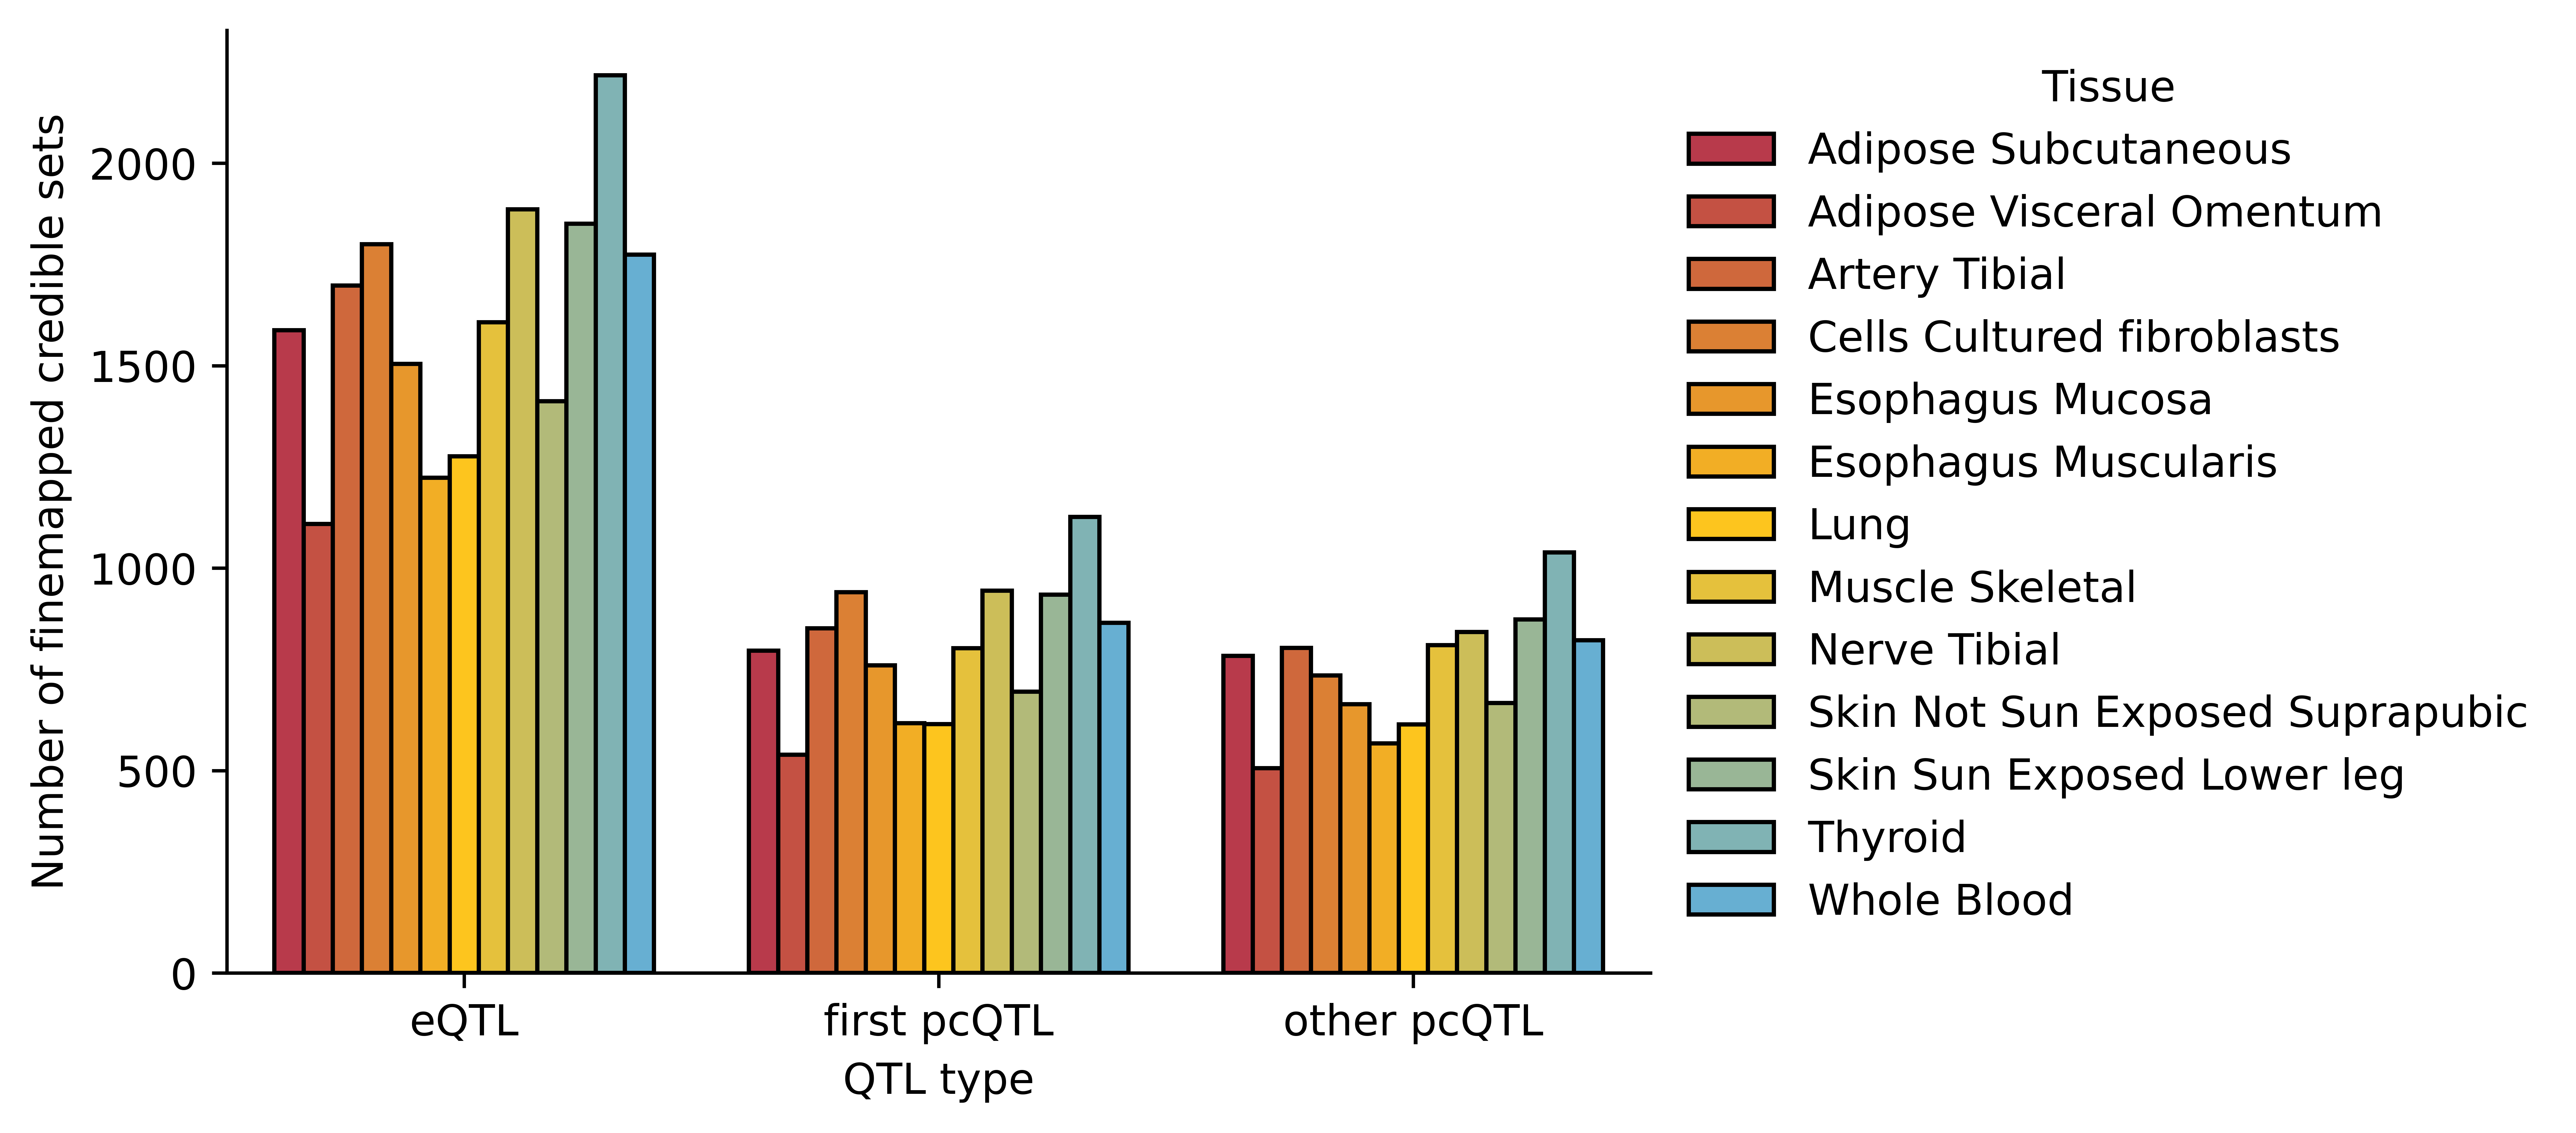

In [24]:
fig, ax = plt.subplots(figsize=(6,4))
y = sns.barplot(pd.melt(counts, id_vars=['tissue']), y='value', hue='tissue', x='variable', ax=ax, palette=tissue_pal, saturation=1, edgecolor='k')
ax.set_xlabel('QTL type')
ax.set_ylabel('Number of finemapped credible sets')
ax.set_xticklabels(['eQTL', 'first pcQTL', 'other pcQTL'])

# Get the current handles and labels
handles, labels = ax.get_legend_handles_labels()

# Replace underscores with spaces in the labels
labels = [label.replace('_', ' ') for label in labels]

# Create a new legend with the updated labels
ax.legend(handles, labels,  frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='Tissue')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.show()

In [13]:
# distribution of pc vs eqlts

# concatenate data over tissues
full_esusie_df = pd.concat(list(susie_control.values()))
full_pcsusie_df = pd.concat(list(susie_pc.values()))

# count how many qtls for each gene 
full_pcsusie_df['gene_id_list'] = full_pcsusie_df['phenotype_id'].str.split('_').str[:-1]
pc1qlts_per_gene = full_pcsusie_df[full_pcsusie_df['pc_num']==1].explode('gene_id_list').groupby('gene_id_list')['cs_id'].nunique()
pc2qlts_per_gene = full_pcsusie_df[full_pcsusie_df['pc_num']==2].explode('gene_id_list').groupby('gene_id_list')['cs_id'].nunique()
pcqlts_per_gene = full_pcsusie_df.explode('gene_id_list').groupby('gene_id_list')['cs_id'].nunique()


full_esusie_df['gene_id'] = full_esusie_df['phenotype_id'].str.split('_').str[-1]
full_esusie_df['phenotype_cs_id'] = full_esusie_df['phenotype_id'] + '_' + full_esusie_df['cs_id'].astype(str)
eqlts_per_gene = full_esusie_df.groupby('gene_id')['phenotype_cs_id'].nunique()

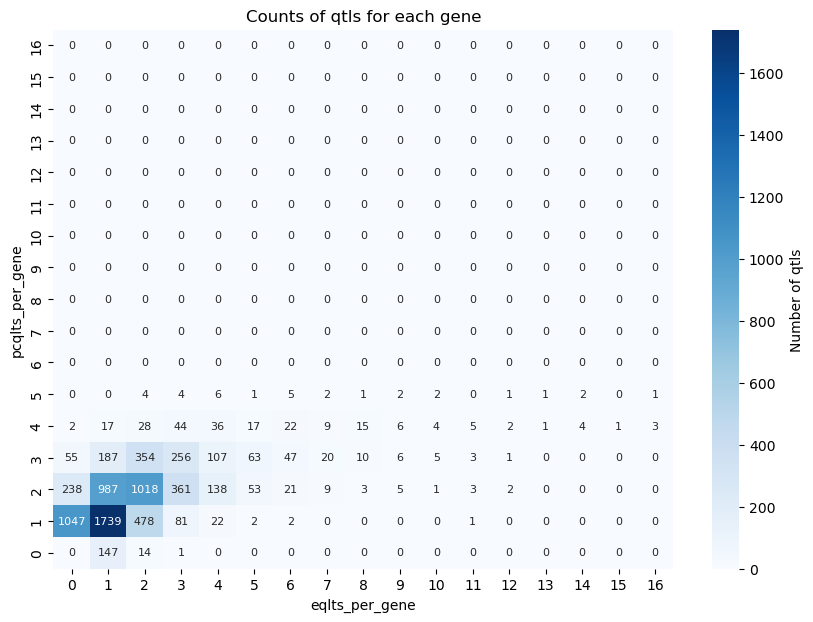

In [14]:
counts = pd.DataFrame({'eqlts_per_gene':eqlts_per_gene, 'pc1qlts_per_gene':pc1qlts_per_gene, 'pc2qlts_per_gene':pc2qlts_per_gene, 'pcqlts_per_gene':pcqlts_per_gene})
counts.replace(np.NAN, 0, inplace=True)

# make the plot

fig, ax = plt.subplots(figsize=(10,7))

# get the 2d histogram bin values
bins=range(int(counts.max().max())+2)
hist_values, x_edges, y_edges = np.histogram2d(counts['pcqlts_per_gene'], counts['eqlts_per_gene'], bins=bins)
df_hist = pd.DataFrame(hist_values)
sns.heatmap(df_hist.astype(int), cbar_kws={'label': 'Number of qtls'}, cmap='Blues', annot=True, annot_kws={"size":8}, ax=ax, fmt='d')
ax.invert_yaxis()
ax.set_ylabel('pcqlts_per_gene')
ax.set_xlabel('eqlts_per_gene')
ax.set_title('Counts of qtls for each gene')
plt.show()

In [15]:
# can do this per cluster instead of per gene

# count how many qtls for each cluster 
full_pcsusie_df['cluster_id'] = full_pcsusie_df['phenotype_id'].str.split('_pc').str[0]
pc1qlts_per_cluster = full_pcsusie_df[full_pcsusie_df['pc_num']==1].groupby('cluster_id')['cs_id'].nunique()
pc2qlts_per_cluster = full_pcsusie_df[full_pcsusie_df['pc_num']==2].groupby('cluster_id')['cs_id'].nunique()
pcqlts_per_cluster = full_pcsusie_df.groupby('cluster_id')['cs_id'].nunique()

full_esusie_df['cluster_id'] = full_esusie_df['phenotype_id'].str.split('_e').str[0]
full_esusie_df['phenotype_cs_id'] = full_esusie_df['phenotype_id'] + '_' + full_esusie_df['cs_id'].astype(str)
eqlts_per_cluster = full_esusie_df.groupby('cluster_id')['phenotype_cs_id'].nunique()


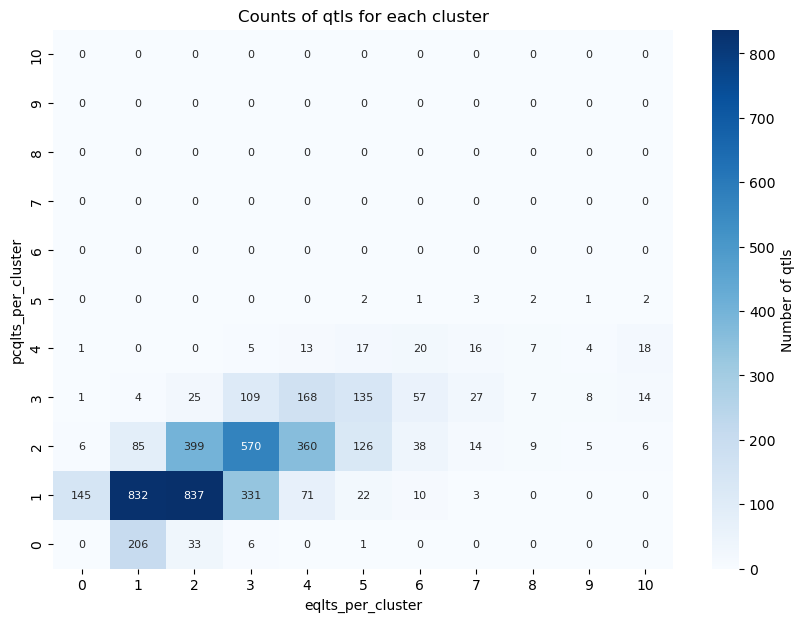

In [16]:
counts = pd.DataFrame({'eqlts_per_cluster':eqlts_per_cluster, 'pcqlts_per_cluster':pcqlts_per_cluster, 'pc1qlts_per_cluster':pc1qlts_per_cluster, 'pc2qlts_per_cluster':pc2qlts_per_cluster})
counts.replace(np.NAN, 0, inplace=True)

# make the plot

fig, ax = plt.subplots(figsize=(10,7))

# get the 2d histogram bin values
clip=10
# uncomment this if you don't want it cliped
#clip=int(counts.max().max())
bins=range(clip+2)

hist_values, x_edges, y_edges = np.histogram2d(counts['pcqlts_per_cluster'].clip(0,clip), counts['eqlts_per_cluster'].clip(0,clip), bins=bins)
df_hist = pd.DataFrame(hist_values)
sns.heatmap(df_hist.astype(int), cbar_kws={'label': 'Number of qtls'}, cmap='Blues', annot=True, annot_kws={"size":8}, ax=ax, fmt='d')
ax.invert_yaxis()
ax.set_ylabel('pcqlts_per_cluster')
ax.set_xlabel('eqlts_per_cluster')
ax.set_title('Counts of qtls for each cluster')
plt.show()

In [17]:
# distribution of signals over cluster size

full_esusie_df['cluster_size'] = full_esusie_df['cluster_id'].str.split('_').apply(len).astype(int)
full_pcsusie_df['cluster_size'] = full_pcsusie_df['cluster_id'].str.split('_').apply(len).astype(int)
full_pcsusie_df['pc_num'] = full_pcsusie_df['phenotype_id'].str.split('_pc').str[-1].astype(int)

